## Importing the required libraries

In [8]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import pandas as pd

## Data

In [155]:
# FEATURES npy (audiofiles in array format):
# https://drive.google.com/file/d/1L2pQ-tyKJ80pJpG8HtXqyAfrvLuvY7Wn/view?usp=sharing

# LABELS cvs:
# https://drive.google.com/open?id=1SE8BFFR-uXUQaMGe-F0cs2a-jpyHTP2m


In [3]:
features = np.load('/home/stjepan/Downloads/training.npy') #loading features data


In [162]:
features[0][0,:].shape   #shape of one sample corresponds to sampling rate*duration (frequency*time)


(110250,)

In [156]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(features):
        mfccs = np.mean(librosa.feature.mfcc(y[0,:], 
                                            sr=44100, #actual sample-rate (checked with audio editor "Audacity")
                                            n_mfcc=26),
                                            axis=0)
        feature = mfccs
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1 
        


In [157]:
df.head(5)

,feature
0,"[5.735180083416181, 4.689635877045118, 2.26977..."
1,"[-2.8083581662585098, -4.742628822073273, -11...."
2,"[0.956286887375573, -1.2995481060617229, -0.31..."
3,"[2.072625571861468, 0.6307368289330955, 1.7738..."
4,"[-1.5676855037213036, -3.9132820767986596, -8...."


In [158]:
df3 = pd.DataFrame(df['feature'].values.tolist()) #Unpacking features

In [159]:
df3.head() #number of columns/features corresponds to mfccs.shape 

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,5.735180,4.689636,2.269777,0.578810,-0.510475,6.298124,7.047494,6.099302,7.664116,7.341090,...,-3.320609,-3.021116,-4.349071,-7.386942,-14.625562,-19.783721,-19.783721,-19.783721,-19.783721,-19.783721
1,-2.808358,-4.742629,-11.271379,-11.618718,-14.015418,-13.524512,-12.914274,-13.424393,-11.692038,-11.125215,...,-20.139208,-20.697500,-21.332812,-21.778720,-22.674451,-22.674451,-22.674451,-22.674451,-22.674451,-22.674451
2,0.956287,-1.299548,-0.316097,1.300920,-0.926437,-0.273497,0.220382,-0.284960,1.519507,1.908047,...,-8.889242,-9.406684,-12.490580,-15.727586,-19.405516,-19.865301,-19.865301,-19.865301,-19.865301,-19.865301
3,2.072626,0.630737,1.773860,3.266194,1.111679,2.712303,3.195792,2.441174,4.222577,4.236691,...,-6.096858,-6.674362,-9.878371,-13.171009,-18.957325,-19.794864,-19.794864,-19.794864,-19.794864,-19.794864
4,-1.567686,-3.913282,-8.287329,-7.087222,-9.345885,-8.948632,-8.396338,-8.891746,-7.076136,-6.509135,...,-16.574802,-17.244952,-19.034728,-19.793534,-21.046743,-21.046743,-21.046743,-21.046743,-21.046743,-21.046743


In [19]:
labels = pd.read_csv("/home/stjepan/Downloads/overdrive_gain_y.csv")  #reading labels from csv

In [22]:
labels.drop(columns="Unnamed: 0", inplace=True)

In [149]:
labels.head(5)

,gain
0,74
1,22
2,54
3,61
4,34


#### Concatenating features and labels

In [24]:
newdf = pd.concat([df3,labels], axis=1)

In [65]:
type(newdf.gain[0])

numpy.int64

In [28]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [30]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,gain
0,5.735180,4.689636,2.269777,0.578810,-0.510475,6.298124,7.047494,6.099302,7.664116,7.341090,...,-3.021116,-4.349071,-7.386942,-14.625562,-19.783721,-19.783721,-19.783721,-19.783721,-19.783721,74
1,-2.808358,-4.742629,-11.271379,-11.618718,-14.015418,-13.524512,-12.914274,-13.424393,-11.692038,-11.125215,...,-20.697500,-21.332812,-21.778720,-22.674451,-22.674451,-22.674451,-22.674451,-22.674451,-22.674451,22
2,0.956287,-1.299548,-0.316097,1.300920,-0.926437,-0.273497,0.220382,-0.284960,1.519507,1.908047,...,-9.406684,-12.490580,-15.727586,-19.405516,-19.865301,-19.865301,-19.865301,-19.865301,-19.865301,54
3,2.072626,0.630737,1.773860,3.266194,1.111679,2.712303,3.195792,2.441174,4.222577,4.236691,...,-6.674362,-9.878371,-13.171009,-18.957325,-19.794864,-19.794864,-19.794864,-19.794864,-19.794864,61
4,-1.567686,-3.913282,-8.287329,-7.087222,-9.345885,-8.948632,-8.396338,-8.891746,-7.076136,-6.509135,...,-17.244952,-19.034728,-19.793534,-21.046743,-21.046743,-21.046743,-21.046743,-21.046743,-21.046743,34


### Shuffling the data

In [31]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,gain
262,-3.378121,-5.258142,-12.163762,-14.256924,-14.439101,-15.101963,-15.965020,-16.733004,-16.798104,-16.223696,...,-20.758489,-21.039582,-21.299956,-21.939142,-22.686939,-23.109025,-23.405967,-23.368588,-22.309022,9
317,-0.268979,-1.043917,-2.894684,-3.574346,-4.154130,-3.683494,-3.956946,-3.836744,-3.017801,-3.199814,...,-7.703501,-8.335626,-7.996669,-8.186814,-8.012991,-8.256973,-7.935953,-3.398928,-0.265670,60
688,-3.289834,-4.513886,-7.499901,-7.225428,-7.402311,-6.960791,-7.185702,-7.397621,-7.236987,-7.693221,...,-10.152328,-10.573615,-11.024503,-11.720609,-12.012282,-12.784174,-13.209759,-14.307638,-12.567834,33
233,-2.199125,-4.099347,-6.480989,-9.008491,-10.787727,-11.150726,-10.939555,-11.598325,-12.140623,-10.730851,...,-21.915571,-21.777101,-21.749371,-21.429347,-21.335484,-22.113627,-22.769076,-22.441792,-20.159330,39
36,-1.728805,-3.174987,-6.439909,-5.800547,-5.356600,-5.155520,-4.666632,-5.574389,-5.728684,-6.666462,...,-3.879882,-3.631510,-3.571778,-3.592470,-2.761811,-2.694570,-3.126757,-4.042609,-4.970779,48
825,-3.261917,-5.234152,-11.118302,-12.172075,-11.676475,-11.489930,-13.083052,-13.895889,-13.491814,-11.688534,...,-11.813608,-11.967520,-12.220397,-13.058876,-14.265571,-14.826639,-15.860284,-16.849912,-15.510043,34
292,0.592618,0.647106,0.504970,0.985641,0.798321,0.952355,1.342704,1.202892,1.768875,1.566784,...,-11.831505,-11.663129,-11.571993,-11.049622,-11.561441,-11.412221,-12.678192,-13.206462,-13.003177,54
518,2.558679,1.485744,2.228115,2.746223,0.844480,2.184350,3.331005,1.124815,1.128171,1.981464,...,1.165243,1.079840,0.747971,0.656871,0.298096,0.733265,1.399471,1.639805,1.269921,58
237,-2.359308,-4.310435,-7.480934,-10.044722,-11.826905,-12.212216,-11.963933,-12.568854,-13.258488,-11.901970,...,-22.625071,-22.651056,-22.639423,-22.073984,-22.163330,-22.688547,-22.711114,-22.244271,-20.889424,36
650,-3.026346,-4.917414,-11.110421,-15.100142,-15.427104,-15.837125,-16.030231,-16.760323,-16.691836,-16.114132,...,-6.171868,-6.556712,-6.920425,-7.509682,-8.220882,-8.886920,-9.752582,-11.166568,-12.543973,18


In [32]:
rnewdf=rnewdf.fillna(0)

### Train/test split

In [33]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [34]:
trainfeatures = train.iloc[:, :-1]

trainlabel = train.iloc[:, -1:]

testfeatures = test.iloc[:, :-1]

testlabel = test.iloc[:, -1:]

In [36]:
from keras.utils import np_utils #not sure if this is necessary

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

### Pading inputs for CNN 

In [160]:
#the shape has to correspond to (nrows, nfeatures, 1)

print('Pad sequences')
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

Pad sequences


In [66]:
x_traincnn.shape, x_testcnn.shape

((783, 216, 1), (217, 216, 1))

## CNN model

In [67]:
model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(1))

opt = keras.optimizers.adam(lr=0.001)

There is a lot room for hyperparameter modification, so don't hesitate to change them

In [41]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 216, 128)          768       
_________________________________________________________________
activation_1 (Activation)    (None, 216, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 216, 128)          82048     
_________________________________________________________________
activation_2 (Activation)    (None, 216, 128)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 27, 128)           82048     
__________

##### Model compiling

In [69]:
model.compile(loss='mse', optimizer=opt, metrics=['mse', 'mae']) #selecting loss fn and metrics

### Model fitting

In [70]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=32, epochs=200, validation_data=(x_testcnn, y_test))

Train on 783 samples, validate on 217 samples
Epoch 1/200
783/783 [==============================] - 4s 5ms/step - loss: 773.9518 - mean_squared_error: 773.9518 - mean_absolute_error: 20.9539 - val_loss: 92.7659 - val_mean_squared_error: 92.7659 - val_mean_absolute_error: 8.1043
Epoch 2/200
783/783 [==============================] - 3s 4ms/step - loss: 64.1790 - mean_squared_error: 64.1790 - mean_absolute_error: 6.4271 - val_loss: 66.9329 - val_mean_squared_error: 66.9329 - val_mean_absolute_error: 6.8766
Epoch 3/200
783/783 [==============================] - 3s 4ms/step - loss: 38.6500 - mean_squared_error: 38.6500 - mean_absolute_error: 4.8483 - val_loss: 50.2020 - val_mean_squared_error: 50.2020 - val_mean_absolute_error: 5.8205
Epoch 4/200
783/783 [==============================] - 3s 4ms/step - loss: 37.7523 - mean_squared_error: 37.7523 - mean_absolute_error: 4.7143 - val_loss: 96.9490 - val_mean_squared_error: 96.9490 - val_mean_absolute_error: 8.5731
Epoch 5/200
783/783 [======

783/783 [==============================] - 3s 4ms/step - loss: 13.5340 - mean_squared_error: 13.5340 - mean_absolute_error: 2.9259 - val_loss: 48.8054 - val_mean_squared_error: 48.8054 - val_mean_absolute_error: 5.5780
Epoch 37/200
783/783 [==============================] - 4s 5ms/step - loss: 10.9519 - mean_squared_error: 10.9519 - mean_absolute_error: 2.6153 - val_loss: 36.0820 - val_mean_squared_error: 36.0820 - val_mean_absolute_error: 5.1444
Epoch 38/200
783/783 [==============================] - 4s 5ms/step - loss: 8.4282 - mean_squared_error: 8.4282 - mean_absolute_error: 2.2710 - val_loss: 28.9829 - val_mean_squared_error: 28.9829 - val_mean_absolute_error: 4.5405
Epoch 39/200
783/783 [==============================] - 3s 3ms/step - loss: 7.0640 - mean_squared_error: 7.0640 - mean_absolute_error: 2.0924 - val_loss: 19.1504 - val_mean_squared_error: 19.1504 - val_mean_absolute_error: 3.4625
Epoch 40/200
783/783 [==============================] - 3s 3ms/step - loss: 7.3525 - mean

Epoch 72/200
783/783 [==============================] - 3s 4ms/step - loss: 6.5268 - mean_squared_error: 6.5268 - mean_absolute_error: 1.9792 - val_loss: 31.5929 - val_mean_squared_error: 31.5929 - val_mean_absolute_error: 4.5700
Epoch 73/200
783/783 [==============================] - 3s 4ms/step - loss: 3.8611 - mean_squared_error: 3.8611 - mean_absolute_error: 1.4974 - val_loss: 27.5028 - val_mean_squared_error: 27.5028 - val_mean_absolute_error: 4.4474
Epoch 74/200
783/783 [==============================] - 3s 4ms/step - loss: 6.4710 - mean_squared_error: 6.4710 - mean_absolute_error: 1.9358 - val_loss: 70.8327 - val_mean_squared_error: 70.8327 - val_mean_absolute_error: 6.8196
Epoch 75/200
783/783 [==============================] - 4s 5ms/step - loss: 7.7719 - mean_squared_error: 7.7719 - mean_absolute_error: 2.1295 - val_loss: 22.5401 - val_mean_squared_error: 22.5401 - val_mean_absolute_error: 3.9635
Epoch 76/200
783/783 [==============================] - 3s 4ms/step - loss: 4.49

Epoch 108/200
783/783 [==============================] - 3s 4ms/step - loss: 7.7591 - mean_squared_error: 7.7591 - mean_absolute_error: 2.1321 - val_loss: 19.0526 - val_mean_squared_error: 19.0526 - val_mean_absolute_error: 3.7797
Epoch 109/200
783/783 [==============================] - 3s 4ms/step - loss: 3.0121 - mean_squared_error: 3.0121 - mean_absolute_error: 1.3433 - val_loss: 18.5637 - val_mean_squared_error: 18.5637 - val_mean_absolute_error: 3.4905
Epoch 110/200
783/783 [==============================] - 3s 4ms/step - loss: 2.3096 - mean_squared_error: 2.3096 - mean_absolute_error: 1.1753 - val_loss: 23.2493 - val_mean_squared_error: 23.2493 - val_mean_absolute_error: 4.0781
Epoch 111/200
783/783 [==============================] - 3s 4ms/step - loss: 2.3708 - mean_squared_error: 2.3708 - mean_absolute_error: 1.1689 - val_loss: 24.4453 - val_mean_squared_error: 24.4453 - val_mean_absolute_error: 4.0576
Epoch 112/200
783/783 [==============================] - 3s 4ms/step - loss:

783/783 [==============================] - 3s 4ms/step - loss: 1.9105 - mean_squared_error: 1.9105 - mean_absolute_error: 1.0699 - val_loss: 11.2452 - val_mean_squared_error: 11.2452 - val_mean_absolute_error: 2.6090
Epoch 144/200
783/783 [==============================] - 3s 4ms/step - loss: 2.5879 - mean_squared_error: 2.5879 - mean_absolute_error: 1.2392 - val_loss: 13.8270 - val_mean_squared_error: 13.8270 - val_mean_absolute_error: 3.0001
Epoch 145/200
783/783 [==============================] - 3s 4ms/step - loss: 2.8672 - mean_squared_error: 2.8672 - mean_absolute_error: 1.3256 - val_loss: 14.9401 - val_mean_squared_error: 14.9401 - val_mean_absolute_error: 3.1529
Epoch 146/200
783/783 [==============================] - 3s 4ms/step - loss: 2.7895 - mean_squared_error: 2.7895 - mean_absolute_error: 1.2940 - val_loss: 18.8801 - val_mean_squared_error: 18.8801 - val_mean_absolute_error: 3.4522
Epoch 147/200
783/783 [==============================] - 4s 5ms/step - loss: 4.1541 - mean

783/783 [==============================] - 3s 4ms/step - loss: 1.6880 - mean_squared_error: 1.6880 - mean_absolute_error: 0.9983 - val_loss: 25.7044 - val_mean_squared_error: 25.7044 - val_mean_absolute_error: 4.1939
Epoch 179/200
783/783 [==============================] - 3s 4ms/step - loss: 3.1301 - mean_squared_error: 3.1301 - mean_absolute_error: 1.3482 - val_loss: 46.5555 - val_mean_squared_error: 46.5555 - val_mean_absolute_error: 5.5763
Epoch 180/200
783/783 [==============================] - 3s 4ms/step - loss: 11.7407 - mean_squared_error: 11.7407 - mean_absolute_error: 2.6546 - val_loss: 44.3459 - val_mean_squared_error: 44.3459 - val_mean_absolute_error: 5.6041
Epoch 181/200
783/783 [==============================] - 3s 4ms/step - loss: 5.0218 - mean_squared_error: 5.0218 - mean_absolute_error: 1.6823 - val_loss: 16.0001 - val_mean_squared_error: 16.0001 - val_mean_absolute_error: 3.3133
Epoch 182/200
783/783 [==============================] - 3s 4ms/step - loss: 2.2290 - me

### Plotting results

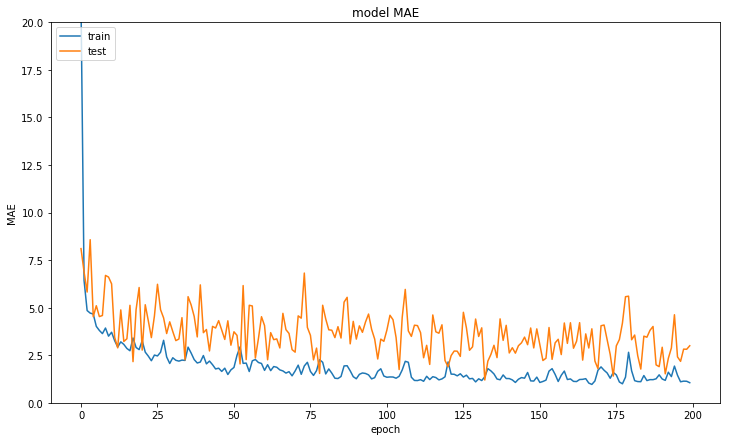

In [73]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 7 #setting figure size


plt.plot(cnnhistory.history['mean_absolute_error'])
plt.plot(cnnhistory.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim(ymax=20)
plt.ylim(ymin=0)
plt.show()

### Saving model

In [151]:
import os
model_name = 'guitar_dist_gain_regression_model_200ep.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /home/stjepan/Documents/_Krish_Suchitra_Tristan_PORTFOLIO/Speech-Emotion-Analyzer-master/saved_models/guitar_dist_gain_regression_model_200ep.h5 


### Predctions

In [153]:
preds = model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)


preds=list(preds[:,0])
actual=list(y_test[:,0])

results = pd.DataFrame({'predicted' : preds, 'actual' : actual})    

results['diff'] = results['predicted'] - results['actual']
#df['diff'].mean()
results.head(15)

217/217 [==============================] - 0s 1ms/step


,predicted,actual,diff
0,36.137444,39,-2.862556
1,20.430946,22,-1.569054
2,51.695141,57,-5.304859
3,27.350233,29,-1.649767
4,48.907528,54,-5.092472
5,52.580601,58,-5.419399
6,63.988621,75,-11.011379
7,45.325882,49,-3.674118
8,43.800793,47,-3.199207
9,65.547287,74,-8.452713


Baseline model predicts gain parameter value of guitar distorstion effect with average error of ~2.6/100